In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.applications import InceptionV3,Xception,ResNet50,VGG16
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from keras.applications.inception_v3 import preprocess_input
from keras import models, layers, optimizers
import glob
import os
import tensorflow as tf
import random
import keras.backend as K
from tensorflow.keras.utils import to_categorical ,Sequence



Using TensorFlow backend.


In [2]:
path=Path('../input/camvid-tiramisu/CamVid')
path_train_annot=path/'trainannot'
path_train=path/'train'
path_test_annot=path/'testannot'
path_test=path/'test'
path_val_annot=path/'valannot'
path_val=path/'val/'
path_out=Path('/kaggle/working')

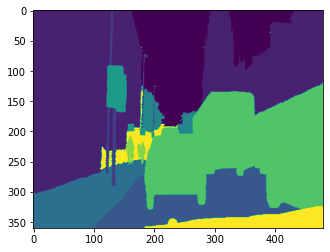

In [3]:
img=cv2.imread('../input/camvid-tiramisu/CamVid/trainannot/0001TP_006690.png',cv2.IMREAD_GRAYSCALE)
# cv2.imshow('image',img)
plt.imshow(img)
plt.show()

In [4]:
img

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11]], dtype=uint8)

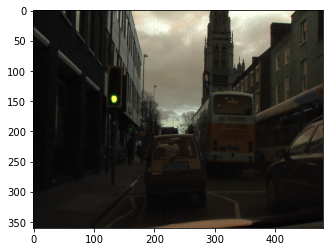

In [5]:
img=cv2.imread('../input/camvid-tiramisu/CamVid/train/0001TP_006690.png')
# cv2.imshow('image',img)
plt.imshow(img)
plt.show()

In [6]:
img

array([[[16, 16, 16],
        [16, 16, 16],
        [12, 12, 12],
        ...,
        [20, 19, 15],
        [20, 18, 17],
        [22, 18, 17]],

       [[16, 16, 16],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [20, 19, 15],
        [21, 19, 18],
        [22, 20, 19]],

       [[14, 14, 14],
        [14, 14, 14],
        [15, 15, 15],
        ...,
        [20, 19, 15],
        [20, 18, 17],
        [20, 17, 16]],

       ...,

       [[19, 17, 16],
        [19, 17, 16],
        [19, 17, 16],
        ...,
        [42, 40, 30],
        [37, 37, 26],
        [38, 33, 21]],

       [[19, 17, 16],
        [19, 17, 16],
        [19, 17, 16],
        ...,
        [40, 37, 27],
        [39, 36, 24],
        [38, 33, 21]],

       [[19, 17, 16],
        [18, 16, 15],
        [18, 16, 15],
        ...,
        [38, 34, 22],
        [38, 35, 23],
        [38, 32, 22]]], dtype=uint8)

In [7]:
codes = np.array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])
len(codes)

12

In [8]:
def make_pairs(img_path,dataset):
    pairs=[]
    for img in os.listdir(img_path):
        pairs.append(('../input/camvid-tiramisu/CamVid/'+dataset+'/'+img,'../input/camvid-tiramisu/CamVid/'+dataset+'annot/'+img))
    return pairs


In [9]:
train_pair=make_pairs(path_train,'train')
val_pair=make_pairs(path_val,'val')
test_pair=make_pairs(path_test,'test')

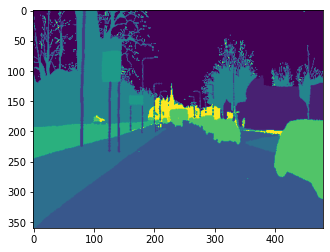

In [10]:
train_pair
img=cv2.imread(train_pair[0][1],cv2.IMREAD_GRAYSCALE)
# cv2.imshow('image',img)
plt.imshow(img)
plt.show()

In [11]:
label=cv2.imread(train_pair[1][1],cv2.IMREAD_GRAYSCALE)
label=cv2.resize(label,(256,256))
# label=to_categorical(label,num_classes=12)
label

array([[ 5,  5,  5, ...,  1,  1,  1],
       [ 5,  5,  5, ...,  1,  1,  1],
       [ 5,  5,  5, ...,  1,  1,  1],
       ...,
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11]], dtype=uint8)

In [12]:
class DataGen(Sequence):
    def __init__(self,pairs,bs,dim,shuffle=True):
        self.pairs=pairs
        self.bs=bs
        self.shuffle=shuffle
        self.dim=dim
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.pairs)/self.bs))
    
    def __getitem__(self,idx):
        indexes=self.indexes[idx*self.bs:(idx+1)*self.bs]
        X,y=self.__data_generation(list(indexes))
        return X,y
    
    def on_epoch_end(self):
        self.indexes=np.arange(len(self.pairs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self,ids):
        batch_imgs=[]
        batch_labels=[]
        
        for i in ids:
            
            img=load_img(self.pairs[i][0],target_size=self.dim)
            img=img_to_array(img)/255.
            batch_imgs.append(img)
            
            label=cv2.imread(self.pairs[i][1],cv2.IMREAD_GRAYSCALE)
            label=cv2.resize(label,(self.dim[0],self.dim[1]))
            label=to_categorical(label,num_classes=12)
            batch_labels.append(label)
            
        return np.array(batch_imgs),np.array(batch_labels)
        
        
        
        



In [13]:
h=128
w=128
c=3
bs=2
train_gen=DataGen(train_pair+test_pair,bs,(h,w,c))
val_gen=DataGen(val_pair,bs,(h,w,c))
# test_gen=DataGen(test_pair,bs,(h,w,c))

In [14]:
X,y=train_gen.__getitem__(1)

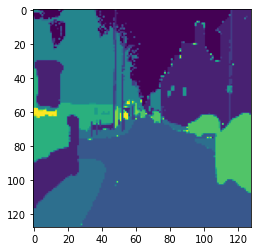

In [15]:
# train_gen = data_gen(str(path_train),str(path_train_annot), bs = 16)
# val_gen = data_gen(str(path_val),str(path_val_annot), bs = 16)
# test_gen=data_gen(str(path_test),str(path_test_annot),bs=16)
plt.imshow(np.argmax(y[1],axis=2))
plt.show()


In [17]:
# h=256
# w=256
# c=3
# bs=16
train_steps=train_gen.__len__()
val_steps=val_gen.__len__()
# test_steps=test_gen.__len__()


In [18]:
def dice_coeff(y_true,y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[0,1,2,3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[0,1,2,3])
    return (numerator + 1) / (denominator + 1)

# def dice_loss(y_true, y_pred):
#     return 1 - dice_coeff(y_true,y_pred)

# def dice_coeff(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     print(y_true_f.shape)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1) 

# def dice_loss(y_true, y_pred):
#     return -dice_coeff(y_true, y_pred)

In [19]:
inputs=Input(shape=(h,w,c))
c1=Conv2D(64,(3,3),padding='same',activation='relu')(inputs)
c1=BatchNormalization()(c1)
c1=Conv2D(64,(3,3),padding='same',activation='relu')(c1)
p1=MaxPooling2D((2, 2))(c1)

c2=Conv2D(128,(3,3),padding='same',activation='relu')(p1)
c2=BatchNormalization()(c2)
c2=Conv2D(128,(3,3),activation='relu',padding='same')(c2)
p2=MaxPooling2D((2, 2))(c2)

c3=Conv2D(256,(3,3),activation='relu',padding='same')(p2)
c3=BatchNormalization()(c3)
c3=Conv2D(256,(3,3),activation='relu',padding='same')(c3)
p3=MaxPooling2D((2, 2))(c3)

c4=Conv2D(512,(3,3),activation='relu',padding='same')(p3)
c4=BatchNormalization()(c4)
c4=Conv2D(512,(3,3),activation='relu',padding='same')(c4)
p4=MaxPooling2D((2, 2))(c4)

c5=Conv2D(1024,(3,3),activation='relu',padding='same')(p4)
c5=BatchNormalization()(c5)
c5=Conv2D(1024,(3,3),activation='relu',padding='same')(c5)

u6=Conv2DTranspose(512,(2,2),strides=(2,2))(c5)
u6=concatenate([u6,c4])
c6=Conv2D(512,(3,3),activation='relu',padding='same')(u6)
c6=BatchNormalization()(c6)
c6=Conv2D(512,(3,3),activation='relu',padding='same')(c6)

u7=Conv2DTranspose(256,(2,2),strides=(2,2))(c6)
u7=concatenate([u7,c3])
c7=Conv2D(256,(3,3),activation='relu',padding='same')(u7)
c7=BatchNormalization()(c7)
c7=Conv2D(256,(3,3),activation='relu',padding='same')(c7)

u8=Conv2DTranspose(128,(2,2),strides=(2,2))(c7)
u8=concatenate([u8,c2])
c8=Conv2D(128,(3,3),activation='relu',padding='same')(u8)
c8=BatchNormalization()(c8)
c8=Conv2D(128,(3,3),activation='relu',padding='same')(c8)

u9=Conv2DTranspose(64,(2,2),strides=(2,2))(c8)
u9=concatenate([u9,c1])
c9=Conv2D(64,(3,3),activation='relu',padding='same')(u9)
c9=BatchNormalization()(c9)
c9=Conv2D(64,(3,3),activation='relu',padding='same')(c9)

out=Conv2D(12,(1,1),activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[out])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [20]:
lr_decay = (1./0.8 -1)/train_steps
opt = Adam(lr=1e-3,beta_1=0.9,beta_2=0.999,decay=lr_decay)
model.compile(optimizer=opt, loss='categorical_crossentropy' ,metrics=['accuracy',dice_coeff])
callbacks = [
             EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, cooldown=0, min_lr=1e-4, verbose=1)
]


In [21]:
model.fit_generator(train_gen,steps_per_epoch=train_steps,validation_data=val_gen,epochs=30,validation_steps=val_steps,callbacks=callbacks)

Epoch 1/30
300/300 [==============================] - 26s 87ms/step - loss: 1.0305 - accuracy: 0.6624 - dice_coeff: 0.5594 - val_loss: 1.5491 - val_accuracy: 0.5625 - val_dice_coeff: 0.5400
Epoch 2/30
300/300 [==============================] - 18s 58ms/step - loss: 0.7505 - accuracy: 0.7611 - dice_coeff: 0.6666 - val_loss: 1.0040 - val_accuracy: 0.6957 - val_dice_coeff: 0.6517
Epoch 3/30
300/300 [==============================] - 17s 57ms/step - loss: 0.6540 - accuracy: 0.8019 - dice_coeff: 0.6940 - val_loss: 0.6750 - val_accuracy: 0.8075 - val_dice_coeff: 0.6519
Epoch 4/30
300/300 [==============================] - 18s 59ms/step - loss: 0.6065 - accuracy: 0.8198 - dice_coeff: 0.7003 - val_loss: 0.7337 - val_accuracy: 0.7937 - val_dice_coeff: 0.6801
Epoch 5/30
300/300 [==============================] - 18s 59ms/step - loss: 0.5834 - accuracy: 0.8285 - dice_coeff: 0.7104 - val_loss: 0.5445 - val_accuracy: 0.8139 - val_dice_coeff: 0.6872
Epoch 6/30
300/300 [==============================

In [28]:
model.save_weights("model.h5")

In [23]:
y_pred=model.predict_generator(val_gen,val_steps)

In [ ]:
y_pred

In [24]:
y_p=np.argmax(y_pred[0],axis=2)
y_p

array([[1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

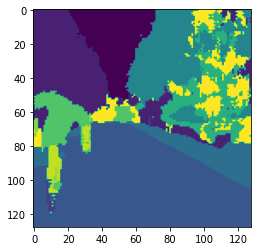

In [25]:
plt.imshow(y_p)
plt.show()

In [26]:
model.evaluate_generator(val_gen,val_steps)

[0.4490410089492798, 0.8728576898574829, 0.7030735611915588]

In [27]:
h=256
w=256
c=3
bs=2
train_gen_256=DataGen(train_pair,bs,(h,w,c))
val_gen_256=DataGen(val_pair,bs,(h,w,c))
test_gen_256=DataGen(test_pair,bs,(h,w,c))

In [29]:
inputs=Input(shape=(h,w,c))
c1=Conv2D(64,(3,3),padding='same',activation='relu')(inputs)
c1=BatchNormalization()(c1)
c1=Conv2D(64,(3,3),padding='same',activation='relu')(c1)
p1=MaxPooling2D((2, 2))(c1)

c2=Conv2D(128,(3,3),padding='same',activation='relu')(p1)
c2=BatchNormalization()(c2)
c2=Conv2D(128,(3,3),activation='relu',padding='same')(c2)
p2=MaxPooling2D((2, 2))(c2)

c3=Conv2D(256,(3,3),activation='relu',padding='same')(p2)
c3=BatchNormalization()(c3)
c3=Conv2D(256,(3,3),activation='relu',padding='same')(c3)
p3=MaxPooling2D((2, 2))(c3)

c4=Conv2D(512,(3,3),activation='relu',padding='same')(p3)
c4=BatchNormalization()(c4)
c4=Conv2D(512,(3,3),activation='relu',padding='same')(c4)
p4=MaxPooling2D((2, 2))(c4)

c5=Conv2D(1024,(3,3),activation='relu',padding='same')(p4)
c5=BatchNormalization()(c5)
c5=Conv2D(1024,(3,3),activation='relu',padding='same')(c5)

u6=Conv2DTranspose(512,(2,2),strides=(2,2))(c5)
u6=concatenate([u6,c4])
c6=Conv2D(512,(3,3),activation='relu',padding='same')(u6)
c6=BatchNormalization()(c6)
c6=Conv2D(512,(3,3),activation='relu',padding='same')(c6)

u7=Conv2DTranspose(256,(2,2),strides=(2,2))(c6)
u7=concatenate([u7,c3])
c7=Conv2D(256,(3,3),activation='relu',padding='same')(u7)
c7=BatchNormalization()(c7)
c7=Conv2D(256,(3,3),activation='relu',padding='same')(c7)

u8=Conv2DTranspose(128,(2,2),strides=(2,2))(c7)
u8=concatenate([u8,c2])
c8=Conv2D(128,(3,3),activation='relu',padding='same')(u8)
c8=BatchNormalization()(c8)
c8=Conv2D(128,(3,3),activation='relu',padding='same')(c8)

u9=Conv2DTranspose(64,(2,2),strides=(2,2))(c8)
u9=concatenate([u9,c1])
c9=Conv2D(64,(3,3),activation='relu',padding='same')(u9)
c9=BatchNormalization()(c9)
c9=Conv2D(64,(3,3),activation='relu',padding='same')(c9)

out=Conv2D(12,(1,1),activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[out])
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 256, 256, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [30]:
model.load_weights("model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',dice_coeff])
callbacks = [
             EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, cooldown=0, min_lr=1e-4, verbose=1)
]

In [31]:
model.fit_generator(train_gen_256,steps_per_epoch=train_steps,validation_data=val_gen_256,epochs=15,validation_steps=val_steps,callbacks=callbacks)

Epoch 1/15
300/300 [==============================] - 39s 130ms/step - loss: 0.5444 - accuracy: 0.8399 - dice_coeff: 0.7136 - val_loss: 1.0952 - val_accuracy: 0.7273 - val_dice_coeff: 0.5214
Epoch 2/15
300/300 [==============================] - 34s 114ms/step - loss: 0.5211 - accuracy: 0.8465 - dice_coeff: 0.7416 - val_loss: 0.5239 - val_accuracy: 0.8496 - val_dice_coeff: 0.7662
Epoch 3/15
300/300 [==============================] - 34s 113ms/step - loss: 0.4630 - accuracy: 0.8638 - dice_coeff: 0.7562 - val_loss: 0.5205 - val_accuracy: 0.8558 - val_dice_coeff: 0.7505
Epoch 4/15
300/300 [==============================] - 37s 124ms/step - loss: 0.4561 - accuracy: 0.8669 - dice_coeff: 0.7697 - val_loss: 0.4522 - val_accuracy: 0.8691 - val_dice_coeff: 0.7318
Epoch 5/15
300/300 [==============================] - 34s 113ms/step - loss: 0.4093 - accuracy: 0.8791 - dice_coeff: 0.7746 - val_loss: 0.4065 - val_accuracy: 0.8625 - val_dice_coeff: 0.7714
Epoch 6/15
300/300 [=========================

In [32]:
y_pred=model.predict_generator(val_gen_256,val_steps)

In [33]:
y_p=np.argmax(y_pred[0],axis=2)
y_p

array([[1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       ...,
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3]])

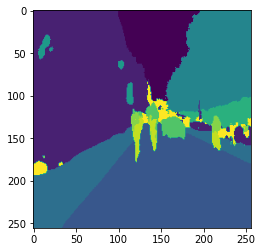

In [34]:
plt.imshow(y_p)
plt.show()